## Chronic Kidney Disease Classification


### Problem Statement

Chronic Kidney Disease (CKD) is a global health crisis characterised by high morbidity and the substantial economic burden of long-term dialysis and hospitalization. Early detection is critical, yet many cases remain undiagnosed until advanced stages. 

This project leverages machine learning to analyse clinical markers and patient data, aiming to identify the primary predictors of CKD. By establishing an evidence-based predictive framework, this study seeks to support clinical decision-making, enabling earlier diagnosis and timely intervention to improve patient outcomes.


In [31]:
# Importing libraries

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

### 1. Load the dataset

In [36]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [38]:
# Check if data loaded correctly
print(f"Training set shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")

print(f"Test set shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

Training set shape: (3500, 10)
Training target shape: (3500, 1)
Test set shape: (1500, 10)
Test target shape: (1500, 1)


In [40]:
# Convert target label to Series
y_train = y_train.squeeze()
y_test = y_test.squeeze()

### 2. Model training

In [43]:
# Initialising cross-validation method
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

In [ ]:
# Preprocessing and creation of pipeline for model training

numeric_features = ['Creatinine', 'BUN', 'GFR', 'Urine_Output', 'Age', 'Protein_in_Urine', 'Water_Intake']
categorical_features = ['Diabetes', 'Hypertension', 'Medication']

# Create the Pipeline using ColumnTransformer
def create_pipeline(model, use_scaling=True):
    # Preprocessor: Scaling and one-hot encoding
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler() if use_scaling else 'passthrough', numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    return pipe

# Fix Target (y), ensuring target (CKD_Status) is numeric BEFORE passing it to the function
y_train = y_train.astype('category').cat.codes
y_test = y_test.astype('category').cat.codes


# Function to train model pipeline and report metrics
def train_model_pipeline(pipeline, x_train, y_train, x_test, y_test, score='accuracy', cv=None):
    # Fit the pipeline (fits scaler on x_train, then fits model on scaled x_train)
    pipeline.fit(x_train, y_train)
    
    # Cross-validation (handles folding and scaling correctly for each fold)
    cv_scores = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring=score)
    mean_cv = np.mean(cv_scores)
    
    # Predict and report
    y_pred = pipeline.predict(x_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Safely get the name of the model
    if hasattr(pipeline, 'named_steps'):
        # If a normal Pipeline
        model_name = type(pipeline.named_steps['classifier']).__name__
    elif hasattr(pipeline, 'estimator'):
        # If RandomizedSearchCV/GridSearchCV object
        model_name = type(pipeline.estimator.named_steps['classifier']).__name__ + " (Optimised)"
    else:
        model_name = "Unknown Model"
    
    # Extract metrics for the positive class (usually '1' or '1.0'), cat.codes usually assigns 1 to the minority/positive class
    pos_label = '1' if '1' in report else '1.0' 
    
    precision = report[pos_label]['precision']
    recall = report[pos_label]['recall']
    f1 = report[pos_label]['f1-score']
    accuracy = report['accuracy']
    
    print(f"--- {model_name} ---")
    print(f"Mean CV: {mean_cv:.4f} | Test Acc: {accuracy:.4f}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}\n")
    
    return pipeline, mean_cv, accuracy, precision, recall, f1
    

#### 2.a Logistic Regresssion

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=33, max_iter=1000)
lr_pipe_scaled = create_pipeline(lr)

lr_pipe, lr_cv, lr_acc, lr_prec, lr_rec, lr_f1 = train_model_pipeline(
    lr_pipe_scaled, X_train, y_train, X_test, y_test, cv=skf
)


--- LogisticRegression ---
Mean CV: 0.9983 | Test Acc: 0.9993
Precision: 0.9975 | Recall: 1.0000 | F1: 0.9987



#### 2.b Support Vector Machine

In [51]:
from sklearn.svm import SVC

svc = SVC(cache_size = 500, random_state = 33)
svc_pipe_scaled = create_pipeline(svc)

svc_pipe, svc_cv, svc_acc, svc_prec, svc_rec, svc_f1 = train_model_pipeline(
    svc_pipe_scaled, X_train, y_train, X_test, y_test, cv=skf
)


--- SVC ---
Mean CV: 0.9934 | Test Acc: 0.9980
Precision: 0.9924 | Recall: 1.0000 | F1: 0.9962



#### 2.c Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 33)
rf_pipe_scaled = create_pipeline(rf)

rf_pipe, rf_cv, rf_acc, rf_prec, rf_rec, rf_f1 = train_model_pipeline(
    rf_pipe_scaled, X_train, y_train, X_test, y_test, cv=skf
)


--- RandomForestClassifier ---
Mean CV: 0.9991 | Test Acc: 1.0000
Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000



#### 2.d MLP Classifier

In [60]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state = 33, max_iter = 1000)
mlp_pipe_scaled = create_pipeline(mlp)

mlp_pipe, mlp_cv, mlp_acc, mlp_prec, mlp_rec, mlp_f1 = train_model_pipeline(
    mlp_pipe_scaled, X_train, y_train, X_test, y_test, cv=skf
)


--- MLPClassifier ---
Mean CV: 0.9983 | Test Acc: 1.0000
Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000



#### 2.e. XGBoost

In [64]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=33,
    eval_metric='logloss'    
)

xgb_pipe_scaled = create_pipeline(xgb_model)

xgb_pipe, xgb_cv, xgb_acc, xgb_prec, xgb_rec, xgb_f1 = train_model_pipeline(
    xgb_pipe_scaled, X_train, y_train, X_test, y_test, cv=skf
)


--- XGBClassifier ---
Mean CV: 0.9991 | Test Acc: 1.0000
Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000



#### Summary of Models, Choosing the Best Model

In [68]:
results_df = pd.DataFrame({
    'Models': ['LR', 'SVC', 'RF', 'MLP', 'XGBoost'],
    'Mean CV': [lr_cv, svc_cv, rf_cv, mlp_cv, xgb_cv],
    'Accuracy': [lr_acc, svc_acc, rf_acc, mlp_acc, xgb_acc],
    'Precision': [lr_prec, svc_prec, rf_prec, mlp_prec, xgb_prec],
    'Recall': [lr_rec, svc_rec, rf_rec, mlp_rec, xgb_rec],
    'F1 Score': [lr_f1, svc_f1, rf_f1, mlp_f1, xgb_f1]
})

# Sort by F1 to see which model misses the fewest cases
print(results_df.sort_values(by='F1 Score', ascending=False))

    Models   Mean CV  Accuracy  Precision  Recall  F1 Score
2       RF  0.999143  1.000000   1.000000     1.0  1.000000
3      MLP  0.998286  1.000000   1.000000     1.0  1.000000
4  XGBoost  0.999143  1.000000   1.000000     1.0  1.000000
0       LR  0.998286  0.999333   0.997468     1.0  0.998733
1      SVC  0.993429  0.998000   0.992443     1.0  0.996207


Ensemble models, such as Random Forest and XGBoost, alongside the Multi-layer Perceptron, achieved the highest scores across all metrics. Given the imbalanced nature of the dataset, these models performed excellently in classifying test instances into the correct labels for both CKD and non-CKD cases. Since the F1-score is the preferred metric for imbalanced data, the strong results here further reflect the robustness of these models.

### 3. Hyperparameter Tuning

Given both ensemble models performed similar in model training I will use Random Forest to use as my chosen model to fine-tune. It may look unnecessary to fien tune this model given the perfect metrics, but the code below just showcase how to perform hyperparameter tuning.

In [74]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from collections import Counter
from scipy.stats import randint

In [75]:
# setting weights to class labels
class_counts = Counter(y_train)
total_instances = len(y_train)

# calculate class weights inversely proportional to class frequencies
class_weight = {labels: total_instances / (len(class_counts) * count) for labels, count in class_counts.items()}
print(class_weight)

{0: 0.6785575804575417, 1: 1.9001085776330076}


In [76]:
# RandomisedSearchCV for RandomForest
parameter_dist = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': [None, 'balanced', class_weight] 
}

# Initialise RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=rf_pipe, 
    param_distributions=parameter_dist, 
    n_iter=20,          
    scoring='f1_macro', 
    cv=skf,             
    verbose=2, 
    random_state=33, 
    n_jobs=-1           
)

# Train using existing training function
best_rf_pipe, rf_cv, rf_acc, rf_prec, rf_rec, rf_f1 = train_model_pipeline(
    rf_random_search, X_train, y_train, X_test, y_test, cv=skf
)

print("Best Hyperparameters:", rf_random_search.best_params_)
print("Best CV Score from Search:", rf_random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
--- RandomForestClassifier (Optimised) ---
Mean CV: 0.9989 | Test Acc: 1.0000
Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000

Best Hyperparameters: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': None, 'classifier__class_weight': None, 'classifier__bootstrap': True}
Best CV Score from Search: 0.998892132394387


### 4. Feature Importance (What are the best indicators of CKD?)

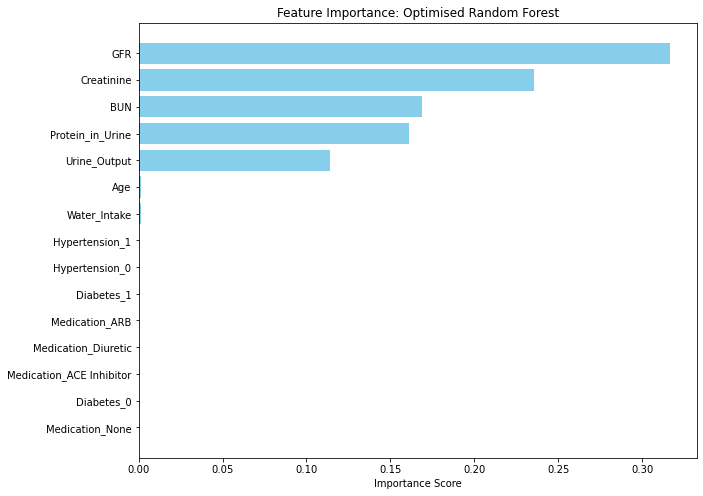

In [80]:
# Obtain best estimator from the search
best_pipe = rf_random_search.best_estimator_

# Get the feature names from the preprocessor
cat_encoder = best_pipe.named_steps['preprocessor'].named_transformers_['cat']
cat_features = list(cat_encoder.get_feature_names_out(categorical_features))
all_features = numeric_features + cat_features

# Get the importances from the classifier step
importances = best_pipe.named_steps['classifier'].feature_importances_

# Create a DataFrame for easy plotting
feat_imp_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance: Optimised Random Forest')
plt.show()


The results indicate that hyperparameter optimization did not yield significant performance gains for the Random Forest Classifier, suggesting the base model was already near its peak performance for this feature set.

The high recall achieved by the ensemble models suggests this pipeline could serve as an effective pre-screening tool to alert clinicians to high-risk patients who require further diagnostic validation.

In line with clinical expectations, the most significant predictors for CKD were GFR, Creatinine, BUN, Protein in Urine, and Urine Output. Interestingly, comorbidities such as diabetes and hypertension were not found to be primary predictors in this specific dataset.

Although this is a synthetic, real-world-based dataset, it accurately reflects established clinical knowledge regarding CKD progression. To further enhance the model's predictive power, future iterations should incorporate additional parameters such as specific urinalysis lab results, patient lifestyle factors, and broader diagnostic findings. Feature engineering, specifically calculating the Urine Protein-to-Creatinine Ratio (UPCR), would be a valuable addition if the data becomes available. Furthermore, aligning the target labeling with KDOQI guidelines—by integrating both Protein in Urine and GFR—could refine the model's clinical validity.

Finally, moving beyond classification, this dataset presents an opportunity for regression modeling using GFR as a continuous target variable to predict the degree of kidney function decline.
